# Reflect Tables into SQLAlchemy ORM

In [128]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [130]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [132]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/3d/95tkjysx02x0l8467qppbwt00000gn/T/ipykernel_96354/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [134]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [136]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [138]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [140]:
# Find the most recent date in the data set.

most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23 00:00:00


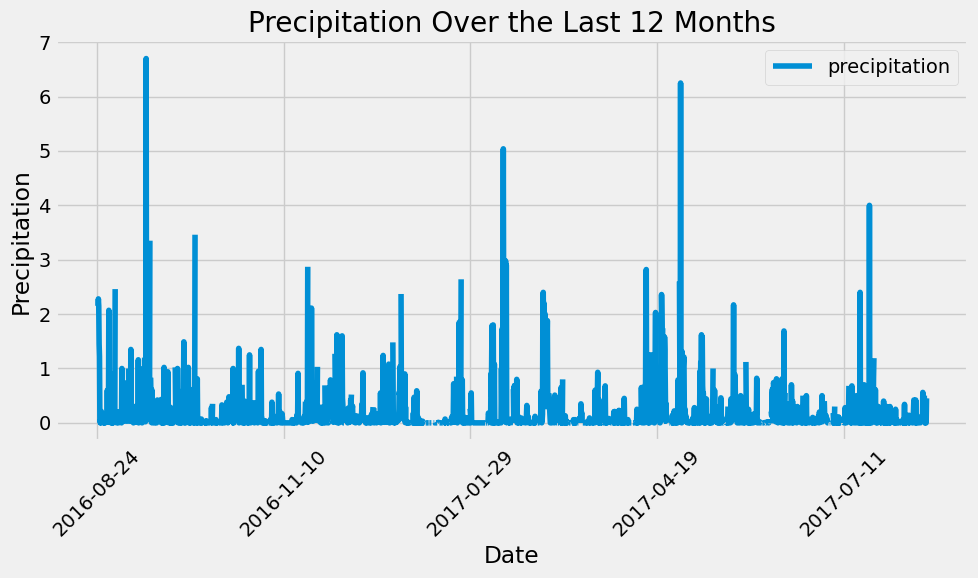

In [142]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date >= one_year_ago)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Set the date column as the index
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(10, 6))
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [144]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df.describe()
summary_stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [146]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [148]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(measurement.station, func.count(measurement.id).label('count'))
    .group_by(measurement.station)
    .order_by(func.count(measurement.id).desc())
    .all()
)

# Display the results
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [150]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Use most active stations ID
most_active_station_id = 'USC00519281'

# Query for the lowest, highest, and average temperature
temperature_stats = (
    session.query(
        func.min(measurement.tobs).label('Lowest Temp'),
        func.max(measurement.tobs).label('Highest Temp'),
        func.avg(measurement.tobs).label('Average Temp')
    )
    .filter(measurement.station == most_active_station_id)
    .all()
)

# Display the results
for lowest, highest, average in temperature_stats:
    print(f"Station ID: {most_active_station_id}")
    print(f"Lowest Temperature: {lowest}")
    print(f"Highest Temperature: {highest}")
    print(f"Average Temperature: {average:.2f}")


Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


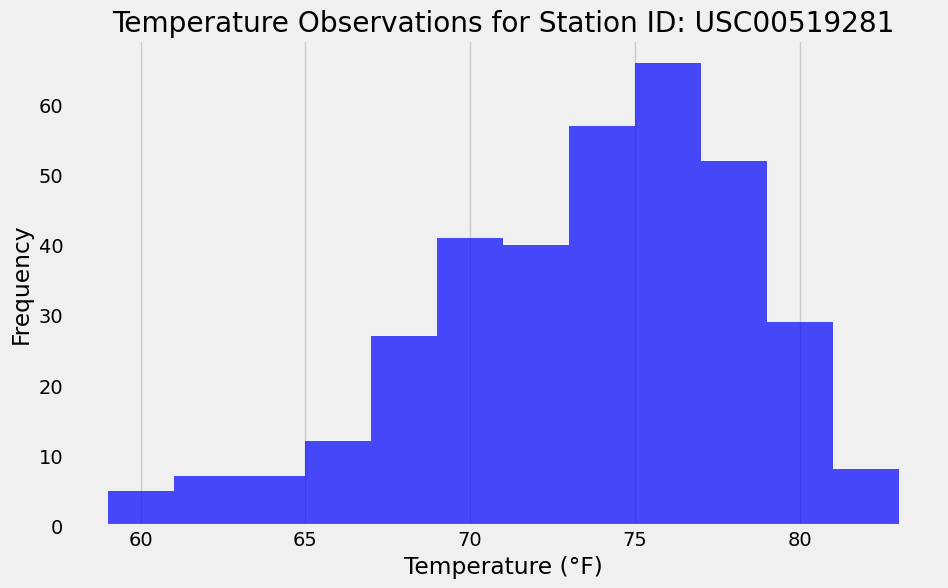

In [152]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Query the last 12 months of temperature observation data
temperature_data = (
    session.query(measurement.tobs)
    .filter(measurement.station == most_active_station_id)
    .filter(measurement.date >= one_year_ago)
    .all()
)

# Convert the results to a pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station ID: {most_active_station_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()



# Close Session

In [154]:
# Close Session
session.close()